In [ ]:
!tar xf C:\\Users\\Timofey\\Downloads\\track_1.tar
# unpacks .tar to somewhere

Распаковал архивчик, потом нужно как-то из него получить dataloader

у меня 2 общие стратегии на уме (я пока не умею никак с фотками работать кроме как давать их нейронкам)

1. фото -> нейронка -> что-то сжатое -> бустинг
2. фото -> нейронка

У меня есть код с дзшек такой. Я думаю надо что-то похожее получить

In [ ]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
device = torch.device('cuda:0')

from tqdm import tqdm
from time import sleep
from PIL import Image

In [ ]:
from skimage import color

class ColorizationDataset(Dataset):
    def __init__(self, path, transform_x, transform_y, is_lab = False):
        self.transform_x = transform_x
        self.transform_y = transform_y
        self.is_lab = is_lab
        filenames = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.jpg') or file.endswith('.JPG'):
                    filenames.append(os.path.join(root, file))

        self.images = []
        for filename in tqdm(filenames):
            try:
                with Image.open(filename) as image:
                    self.images.append(image.copy())
            except:
                pass
                #print('Could not load image:', filename)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        Y = self.transform_y(img)
        if self.is_lab:
            Y = color.rgb2lab(to_numpy_image(Y))
            Y = to_torch_tensor(Y)
        X = self.transform_x(Y)
        return X, Y

In [ ]:
dataset = ColorizationDataset('universum-photos', to_grayscale, transform_all) # какие-то параметры - не оч важно какие
loader = DataLoader(dataset, batch_size=32, shuffle=True)



---

# Solution


In [ ]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
device = torch.device('cuda:0')

from tqdm import tqdm
from PIL import Image
from skimage import color

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error

In [ ]:
image_size = 256
class IDAO_data(Dataset):
    def __init__(self, path, transforms_img, is_train=True):
        self.is_train = is_train
        self.transforms_img = transforms_img
        filenames = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.png') or file.endswith('.PNG'):
                    filenames.append(os.path.join(root, file))

        self.images = []
        self.paths = []
        for filename in tqdm(filenames):
            try:
                with Image.open(filename) as image:
                    self.images.append(image.copy())
                    self.paths.append(filename)
            except:
                print('Could not load image:', filename)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        return self.transforms_img(img).view(1, image_size, image_size), idx
    
    def get_image(self, idx):
        return self.images[idx]

    def get_filename(self, idx):
        return self.paths[idx]

In [ ]:
transforms_all = transforms.Compose([
    transforms.CenterCrop((image_size, image_size)),
    # transforms.ColorJitter(contrast=[2.5, 2.5]),
    transforms.ColorJitter(contrast=[3.0, 3.0]),
    transforms.ToTensor(),
])

# dataset = IDAO_data('idao_dataset\\train', transforms_all)
dataset_test = IDAO_data('idao_dataset\\test_new', transforms_all)
# len_train = int(len(dataset) * 0.9)
# len_test = len(dataset) - len_train
# dataset_train, dataset_val = random_split(dataset, [len_train, len_test])
# loader = DataLoader(dataset, batch_size=16, shuffle=True) 
loader_test = DataLoader(dataset_test, batch_size=8, shuffle=False) 

100%|███████████████████████████████████████████████████████████████████████████| 16560/16560 [01:49<00:00, 151.00it/s]


In [ ]:
len_test

1341

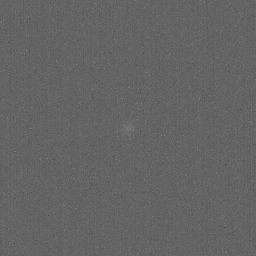

In [ ]:
transforms.CenterCrop((256, 256))(dataset.get_image(dataset_train[1335][1]))

Теперь у нас есть DataLoader, и мы можем по нему итерироваться. К тому же есть *dataset*. У него есть такой функционал:


* [i] -- returns (torch tensor of shape (1, h, w), i)  of *i*-th image
* get_filename(i) -- returns path of *i*-th image
* get_image(i) -- returns PIL.Image of *i*-th image

In [ ]:
dataset_test.get_filename(1)

'idao_dataset\\test_new\\private_test\\0005564c011259402dcb6e3beb6e64d285124fa0.png'

In [ ]:
def parse_filename(name):
    index = name.find("_ER_")
    if (index == -1):
        index = name.find("_NR_")
    type_ = name[index + 1] + name[index + 2]
    index += 4
    num = ""
    while (name[index].isdigit()):
        num = num + name[index]
        index += 1
    num = int(num)
    return (type_, num)

def get_true_classifier(data):
    arr = []
    for _, i in data:
        tp, num = parse_filename(dataset.get_filename(i))
        if (tp == "NR"):
            arr.append(1)
        else:
            arr.append(0)
    return np.array(arr)

def get_result_classifier(model, data):
    arr = []
    for X, i in data:
        predicted = model(X.view(1, 1, image_size, image_size).cuda())
        arr.append(predicted.detach().view(2).argmax().item())
    return np.array(arr)

def get_result_proba(model, data):
    arr = []
    for X, i in data:
        predicted = model(X.view(1, 1, image_size, image_size).cuda())
        arr.append(predicted.detach().view(2)[1].item() - predicted.detach().view(2)[0].item())
    return np.array(arr)

In [ ]:
def roc_auc_score_(model, validation_data):
    return roc_auc_score(get_true_classifier(validation_data), get_result_proba(model, validation_data))

def accuracy_score_(model, validation_data):
    return accuracy_score(get_true_classifier(validation_data), get_result_classifier(model, validation_data))

In [ ]:
def kev_transform(kev_val):
    # return kev_val / 30
    if kev_val == 1:
        return 0
    if kev_val == 3:
        return 1
        # return (1 / 12) * 1 + (1 / 6) * 1
    if kev_val == 6:
        return 2
        # return (1 / 12) * 1 + (1 / 6) * 2
    if kev_val == 10:
        return 3
        # return (1 / 12) * 1 + (1 / 6) * 3
    if kev_val == 20:
        return 4
        # return (1 / 12) * 1 + (1 / 6) * 4
    if kev_val == 30:
        return 5
        # return (1 / 12) * 1 + (1 / 6) * 5

def kev_inverse_transform(value):
    values = [1, 3, 6, 10, 20, 30]
    return values[value]
    # return value * 30
    # if value < (1 / 6) * 1:
    #     return 1
    # if value < (1 / 6) * 2:
    #     return 3
    # if value < (1 / 6) * 3:
    #     return 6
    # if value < (1 / 6) * 4:
    #     return 10
    # if value < (1 / 6) * 5:
    #     return 20
    return 30

In [ ]:
def get_true_regression(data):
    arr = []
    for _, i in data:
        tp, num = parse_filename(dataset.get_filename(i))
        arr.append(num)
    return np.array(arr)

In [ ]:
def get_predicted_regression(model, data):
    arr = []
    for X, i in data:
        num = model(X.view(1, 1, image_size, image_size).cuda()).detach().view(6).argmax().item()
        # print(model(X.view(1, 1, 300, 300).cuda()).detach())
        arr.append(kev_inverse_transform(num))
    return np.array(arr)

In [ ]:
def mae(model, validation_data):
    return mean_absolute_error(get_true_regression(validation_data), get_predicted_regression(model, validation_data))

In [ ]:
def train_model(model, train_data):
    raise NotImplementedError()

In [ ]:
def predict(model, data):
    raise NotImplementedError()



---

## Classification

In [ ]:
def get_classes(y):
    classes = np.zeros(len(y))
    for i in range(len(y)):
        if parse_filename(dataset.get_filename(y[i]))[0] == 'NR':
            classes[i] = 1
    return torch.tensor(classes, dtype=torch.long)

In [ ]:
Baseline_model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=1, padding_mode='reflect'),
    nn.SiLU(),
    nn.Dropout(p=0.1),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, padding_mode='reflect'),
    nn.SiLU(),
    nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(3, 3), padding=1, padding_mode='reflect'),
    nn.SiLU(),
    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, padding_mode='reflect'),
    nn.SiLU(),
    nn.Conv2d(in_channels=16, out_channels=2, kernel_size=(256, 256), padding=0, padding_mode='reflect'),
    nn.LogSoftmax(dim=1)
    ).cuda()

In [ ]:
optimizer = torch.optim.Adam(Baseline_model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

In [ ]:
for epoch in range(17):
    losses = []
    for X, y in tqdm(loader):
        # get_classes(y)
        # break
        optimizer.zero_grad()
        # print(X.shape)
        y_pred = Baseline_model(X.cuda())
        y_true = get_classes(y).cuda()
        loss = criterion(y_pred.view(-1, 2), y_true)
        # print(get_classes(y))
        loss.backward()
        losses.append(loss.item())
        optimizer.step()

        X = X.detach().cpu()
        y_pred = y_pred.detach().cpu()
        y_true = y_true.detach().cpu()
        loss = loss.detach().cpu()
        torch.cuda.empty_cache()
        # ну вроде нормас
    if epoch % 1 == 0:
        # print('epoch:', epoch, '| accuracy score:', accuracy_score_(Baseline_model, dataset_test), '| auc-roc:', roc_auc_score_(Baseline_model, dataset_test))
        print('epoch:', epoch)
    # if epoch == 0:
    #     print('epoch:', epoch, '| accuracy score:', accuracy_score_(Baseline_model, dataset_val), '| auc-roc:', roc_auc_score_(Baseline_model, dataset_val))

  0%|                                                                                          | 0/838 [00:00<?, ?it/s]

epoch: 0


  0%|                                                                                          | 0/838 [00:00<?, ?it/s]

epoch: 1


  0%|                                                                                          | 0/838 [00:00<?, ?it/s]

epoch: 2


  0%|                                                                                          | 0/838 [00:00<?, ?it/s]

epoch: 3


  0%|                                                                                          | 0/838 [00:00<?, ?it/s]

epoch: 4


  0%|                                                                                          | 0/838 [00:00<?, ?it/s]

epoch: 5


  0%|                                                                                          | 0/838 [00:00<?, ?it/s]

epoch: 6


  0%|                                                                                          | 0/838 [00:00<?, ?it/s]

epoch: 7


  0%|                                                                                          | 0/838 [00:00<?, ?it/s]

epoch: 8


  0%|                                                                                          | 0/838 [00:00<?, ?it/s]

epoch: 9


  0%|                                                                                          | 0/838 [00:00<?, ?it/s]

epoch: 10


  0%|                                                                                          | 0/838 [00:00<?, ?it/s]

epoch: 11


  0%|                                                                                          | 0/838 [00:00<?, ?it/s]

epoch: 12


  0%|                                                                                          | 0/838 [00:00<?, ?it/s]

epoch: 13


  0%|                                                                                          | 0/838 [00:00<?, ?it/s]

epoch: 14


  0%|                                                                                          | 0/838 [00:00<?, ?it/s]

epoch: 15


100%|████████████████████████████████████████████████████████████████████████████████| 838/838 [04:00<00:00,  3.49it/s]

epoch: 16


In [ ]:
torch.save(Baseline_model.state_dict(), 'C:\\Users\\Timofey\\class_idao_2.pth') # <-- save model

In [ ]:
optimizer = torch.optim.Adam(Baseline_model.parameters(), lr=0.001)
for epoch in range(10):
    losses = []
    for X, y in loader:
        # get_classes(y)
        # break
        optimizer.zero_grad()
        # print(X.shape)
        y_pred = Baseline_model(X.cuda())
        y_true = get_classes(y).cuda()
        loss = criterion(y_pred.view(-1, 2), y_true)
        # print(get_classes(y))
        loss.backward()
        losses.append(loss.item())
        optimizer.step()

        X = X.detach().cpu()
        y_pred = y_pred.detach().cpu()
        y_true = y_true.detach().cpu()
        loss = loss.detach().cpu()
        torch.cuda.empty_cache()
        # ну вроде нормас
    if epoch % 3 == 0:
        print('epoch:', epoch, '| accuracy score:', accuracy_score_(Baseline_model, dataset_test), '| auc-roc:', roc_auc_score_(Baseline_model, dataset_test))

epoch: 0 | accuracy score: 0.9895600298284862 | auc-roc: 0.9997820139244167
epoch: 3 | accuracy score: 0.9947800149142431 | auc-roc: 0.9996641234957849
epoch: 6 | accuracy score: 0.9932885906040269 | auc-roc: 0.9983428609560246
epoch: 9 | accuracy score: 0.9970171513795675 | auc-roc: 0.998758813977801


In [ ]:
for epoch in range(19): # old, no_transforms
    losses = []
    for X, y in loader:
        # get_classes(y)
        # break
        optimizer.zero_grad()
        # print(X.shape)
        y_pred = Baseline_model(X.cuda())
        y_true = get_classes(y).cuda()
        loss = criterion(y_pred.view(-1, 2), y_true)
        # print(get_classes(y))
        loss.backward()
        losses.append(loss.item())
        optimizer.step()

        X = X.detach().cpu()
        y_pred = y_pred.detach().cpu()
        y_true = y_true.detach().cpu()
        loss = loss.detach().cpu()
        torch.cuda.empty_cache()
        # ну вроде нормас
    if epoch % 3 == 0:
        print('epoch:', epoch, '| accuracy score:', accuracy_score_(Baseline_model, dataset_test), '| auc-roc:', roc_auc_score_(Baseline_model, dataset_test))

epoch: 0 | accuracy score: 0.9946751863684771 | auc-roc: 0.9993101570300444
epoch: 3 | accuracy score: 0.9946751863684771 | auc-roc: 0.9992239266588001
epoch: 6 | accuracy score: 0.9787007454739084 | auc-roc: 0.9990469274757193
epoch: 9 | accuracy score: 0.9904153354632588 | auc-roc: 0.9991785422528818
epoch: 12 | accuracy score: 0.9882854100106496 | auc-roc: 0.9972406281201779
epoch: 15 | accuracy score: 0.9946751863684771 | auc-roc: 0.9988200054461287
epoch: 18 | accuracy score: 0.9925452609158679 | auc-roc: 0.9977897794317873


In [ ]:
print('epoch:', epoch, '| accuracy score:', accuracy_score_(Baseline_model, dataset_test), '| auc-roc:', roc_auc_score_(Baseline_model, dataset_test))

epoch: 19 | accuracy score: 0.9914802981895634 | auc-roc: 0.9989879277480258


In [ ]:
optimizer = torch.optim.Adam(Baseline_model.parameters(), lr=0.001)

In [ ]:
for epoch in range(1):
    losses = []
    for X, y in loader:
        X = X.cuda()
        # get_classes(y)
        # break
        optimizer.zero_grad()
        # print(X.shape)
        y_pred = Baseline_model(X)
        y_true = get_classes(y)
        y_true = y_true.cuda()
        loss = criterion(y_pred.view(-1, 2), y_true)
        # print(get_classes(y))
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        # ну вроде нормас
    
    print('epoch:', epoch, '| accuracy score:', accuracy_score_(Baseline_model, dataset_test), '| auc-roc:', roc_auc_score_(Baseline_model, dataset_test))

epoch: 0 | accuracy score: 0.7242921013412816 | auc-roc: 0.7913668424052436


## Regression

In [ ]:
def get_true_kev(y):
    arr = []
    for i in y:
        tp, num = parse_filename(dataset.get_filename(i))
        arr.append(kev_transform(num))
    # print(arr)
    return torch.tensor(np.array(arr), dtype=torch.float).view(len(y), 1)

In [ ]:
Baseline_model_regression = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=1, padding_mode='reflect'),
    nn.SiLU(),
    nn.Dropout(p=0.1),
    nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 3), padding=1, padding_mode='reflect'),
    nn.SiLU(),
    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, padding_mode='reflect'),
    nn.SiLU(),
    nn.Conv2d(in_channels=16, out_channels=1, kernel_size=(300, 300), padding=0, padding_mode='reflect'),
    # nn.Sigmoid(),
    ).cuda()

In [ ]:
optimizer = torch.optim.Adam(Baseline_model_regression.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [ ]:
for epoch in range(10):
    losses = []
    for X, y in loader:
        optimizer.zero_grad()
        y_pred = Baseline_model_regression(X.cuda())
        loss = criterion(y_pred.view(-1, 1), get_true_kev(y).cuda())
        # break
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    # print(epoch)
    if epoch % 3 == 0:
        print('epoch:', epoch, '| mae:', mae(Baseline_model_regression, dataset_test), '| mean_mse_losses:', np.mean(np.array(losses)), '| batches:', len(losses))

epoch: 0 | mae: 7.996095545295456 | mean_mse_losses: 4.092220810000543 | batches: 378
epoch: 3 | mae: 4.868535662090752 | mean_mse_losses: 0.03300221115055065 | batches: 378


KeyboardInterrupt: ignored

In [ ]:
mae(Baseline_model_regression, dataset_test)

11.662317701746133

In [ ]:
class Regression_model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, (3, 3), padding=1, padding_mode='reflect'),
            nn.SiLU(), 
            nn.Conv2d(64, 64, (3, 3), padding=1, padding_mode='reflect'),
            nn.SiLU(), 
            nn.MaxPool2d((2, 2), stride=(2, 2)), # (*, 64, 128, 128)
            nn.Conv2d(64, 128, (3, 3), padding=1, padding_mode='reflect'),
            nn.SiLU(),
            nn.AvgPool2d((2, 2), stride=(2, 2)), # (*, 128, 64, 64)
            nn.Conv2d(128, 128, (3, 3), padding=1, padding_mode='reflect'),
            nn.SiLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, (5, 5), padding=2, padding_mode='reflect'), 
            nn.SiLU(),
            nn.Conv2d(256, 256, (5, 5), padding=2, padding_mode='reflect'), 
            nn.SiLU(),
            nn.MaxPool2d((2, 2), stride=(2, 2)), # (*, 256, 32, 32)
            nn.Conv2d(256, 256, (5, 5), padding=2, padding_mode='reflect'), 
            nn.SiLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, (5, 5), padding=2, padding_mode='reflect'), 
            nn.SiLU(),
            nn.Conv2d(256, 256, (5, 5), padding=2, padding_mode='reflect'), 
            nn.SiLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, (5, 5), padding=2, padding_mode='reflect'), 
            nn.SiLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, (3, 3), padding=1, padding_mode='reflect'), 
            nn.SiLU(),
            nn.MaxPool2d((2, 2), stride=(2, 2)), # (*, 256, 16, 16)
            nn.Conv2d(256, 256, (3, 3), padding=1, padding_mode='reflect'), 
            nn.SiLU(),
            nn.MaxPool2d((2, 2), stride=(2, 2)), # (*, 256, 8, 8)
            nn.Conv2d(256, 256, (3, 3), padding=1, padding_mode='reflect'), 
            nn.SiLU(),
            nn.MaxPool2d((2, 2), stride=(2, 2)), # (*, 256, 4, 4)
            nn.Conv2d(256, 128, (3, 3), padding=1, padding_mode='reflect'), 
            nn.SiLU(),
            nn.Conv2d(128, 64, (3, 3), padding=1, padding_mode='reflect'), 
            nn.SiLU(),
            # nn.MaxPool2d((2, 2), stride=(2, 2)), # (*, 64, 2, 2)
            nn.Conv2d(64, 64, (3, 3), padding=1, padding_mode='reflect'), 
            nn.SiLU(),
            nn.Conv2d(64, 32, (3, 3), padding=1, padding_mode='reflect'), 
            nn.SiLU(),
            nn.Conv2d(32, 1, (4, 4), padding=0, padding_mode='reflect'), 
            nn.SiLU(),
            # nn.MaxPool2d((2, 2), stride=(2, 2)), # (*, 4, 1, 1)
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        h = self.encoder(x)
        # h = torch.cat((h, x), 1)
        return h

In [ ]:
def train_model(epochs=3, lr=0.0001, verbose=True):
    # Here we train our model
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) # can change lr for better score - learning rate in gradient descent. Maybe can change optimizer, but Adam is good
    criterion = nn.L1Loss() # can change loss criterion
    if verbose:
        print('Training model...',
              'Optimizer: ' + str(optimizer), 
              'Criterion: ' + str(criterion),
              'epochs: ' + str(epochs),
              sep='\n'
              )

    for epoch in range(epochs): # can change number of epochs - the more the better. But one epoch = ~10 minutes
        losses = []
        for X, y in loader:
            optimizer.zero_grad()
            y_pred = model(X.cuda())
            loss = criterion(y_pred.view(-1, 1), get_true_kev(y).cuda())
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
        print('epoch:', epoch + 1, 'of', epochs, '\nmean_loss:', np.mean(losses))
        plt.plot(losses)
        plt.show()
    
    if verbose:
        print('Training finished')

Training model...
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)
Criterion: L1Loss()
epochs: 1
epoch: 1 of 1 
mean_loss: 0.6109835127574708


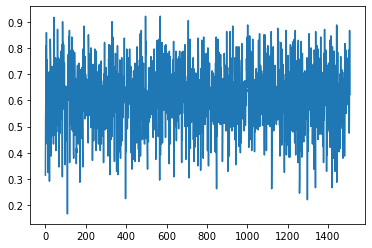

Training finished
Training model...
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
Criterion: L1Loss()
epochs: 1
epoch: 1 of 1 
mean_loss: 0.3506219962116817


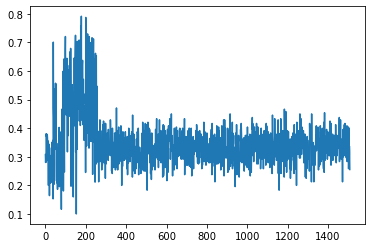

Training finished
Training model...
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0005
    weight_decay: 0
)
Criterion: L1Loss()
epochs: 1
epoch: 1 of 1 
mean_loss: 0.22646747709229104


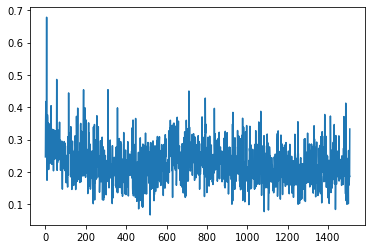

Training finished
Training model...
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 7.5e-05
    weight_decay: 0
)
Criterion: L1Loss()
epochs: 1
epoch: 1 of 1 
mean_loss: 0.20196394245846924


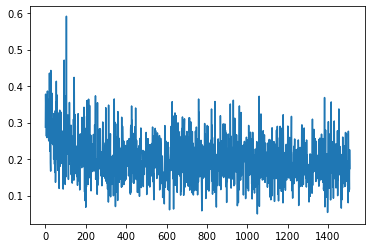

Training finished
Training model...
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-05
    weight_decay: 0
)
Criterion: L1Loss()
epochs: 1
epoch: 1 of 1 
mean_loss: 0.20302360546833795


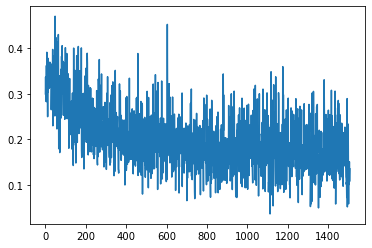

Training finished


In [ ]:
for lr in [0.01, 0.001, 0.0005, 0.000075, 0.00001]:
    model = Regression_model().cuda()
    train_model(epochs=1, lr=lr)
    # mae(model, dataset_test)

## Regression -> Classification

In [ ]:
def get_true_kev_classes(y):
    arr = []
    for i in y:
        tp, num = parse_filename(dataset.get_filename(i))
        arr.append(kev_transform(num))
    # print(arr)
    return torch.tensor(arr, dtype=torch.long)

In [ ]:
#@title Default title text
# class Reg_via_Class(nn.Module):
#     def __init__(self):
#         super().__init__()
        
#         self.encoder = nn.Sequential(
#             nn.Conv2d(1, 64, (3, 3), padding=1, padding_mode='reflect'),
#             nn.SiLU(), 
#             nn.Conv2d(64, 64, (3, 3), padding=1, padding_mode='reflect'),
#             nn.SiLU(), 
#             nn.MaxPool2d((2, 2), stride=(2, 2)), # (*, 64, 128, 128)
#             nn.Conv2d(64, 128, (3, 3), padding=1, padding_mode='reflect'),
#             nn.SiLU(),
#             nn.AvgPool2d((2, 2), stride=(2, 2)), # (*, 128, 64, 64)
#             nn.Conv2d(128, 128, (3, 3), padding=1, padding_mode='reflect'),
#             nn.SiLU(),
#             nn.BatchNorm2d(128),
#             nn.Conv2d(128, 256, (5, 5), padding=2, padding_mode='reflect'), 
#             nn.SiLU(),
#             nn.Conv2d(256, 256, (5, 5), padding=2, padding_mode='reflect'), 
#             nn.SiLU(),
#             nn.MaxPool2d((2, 2), stride=(2, 2)), # (*, 256, 32, 32)
#             nn.Conv2d(256, 256, (5, 5), padding=2, padding_mode='reflect'), 
#             nn.SiLU(),
#             nn.BatchNorm2d(256),
#             nn.Conv2d(256, 256, (5, 5), padding=2, padding_mode='reflect'), 
#             nn.SiLU(),
#             nn.Dropout(0.1),
#             nn.Conv2d(256, 256, (5, 5), padding=2, padding_mode='reflect'), 
#             nn.SiLU(),
#             nn.BatchNorm2d(256),
#             nn.Conv2d(256, 256, (5, 5), padding=2, padding_mode='reflect'), 
#             nn.SiLU(),
#             nn.BatchNorm2d(256),
#             nn.Conv2d(256, 256, (3, 3), padding=1, padding_mode='reflect'), 
#             nn.SiLU(),
#             nn.MaxPool2d((2, 2), stride=(2, 2)), # (*, 256, 16, 16)
#             nn.Conv2d(256, 256, (3, 3), padding=1, padding_mode='reflect'), 
#             nn.SiLU(),
#             nn.MaxPool2d((2, 2), stride=(2, 2)), # (*, 256, 8, 8)
#             nn.Conv2d(256, 256, (3, 3), padding=1, padding_mode='reflect'), 
#             nn.SiLU(),
#             nn.Dropout(0.1),
#             nn.MaxPool2d((2, 2), stride=(2, 2)), # (*, 256, 4, 4)
#             nn.Conv2d(256, 128, (3, 3), padding=1, padding_mode='reflect'), 
#             nn.SiLU(),
#             nn.Conv2d(128, 64, (3, 3), padding=1, padding_mode='reflect'), 
#             nn.SiLU(),
#             # nn.MaxPool2d((2, 2), stride=(2, 2)), # (*, 64, 2, 2)
#             nn.Conv2d(64, 64, (3, 3), padding=1, padding_mode='reflect'), 
#             nn.SiLU(),
#             nn.Conv2d(64, 32, (3, 3), padding=1, padding_mode='reflect'), 
#             nn.SiLU(),
#             nn.Conv2d(32, 6, (4, 4), padding=0, padding_mode='reflect'),
#             # nn.MaxPool2d((2, 2), stride=(2, 2)), # (*, 4, 1, 1)
#             nn.LogSoftmax(dim=1),
#         )
    
#     def forward(self, x):
#         h = self.encoder(x)
#         # h = torch.cat((h, x), 1)
#         return h

class Reg_via_Class(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, (3, 3), padding=1, padding_mode='reflect'),
            nn.SiLU(), 
            nn.Conv2d(64, 64, (3, 3), padding=1, padding_mode='reflect'),
            nn.SiLU(), 
            nn.MaxPool2d((2, 2), stride=(2, 2)), # (*, 64, 128, 128)
            nn.Conv2d(64, 128, (3, 3), padding=1, padding_mode='reflect'),
            nn.SiLU(),
            nn.AvgPool2d((2, 2), stride=(2, 2)), # (*, 128, 64, 64)
            nn.Conv2d(128, 128, (3, 3), padding=1, padding_mode='reflect'),
            nn.SiLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, (5, 5), padding=2, padding_mode='reflect'), 
            nn.SiLU(),
            nn.Conv2d(256, 256, (9, 9), padding=4, padding_mode='reflect'), 
            nn.SiLU(),
            nn.MaxPool2d((2, 2), stride=(2, 2)), # (*, 256, 32, 32)
            nn.Conv2d(256, 256, (5, 5), padding=2, padding_mode='reflect'), 
            nn.SiLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, (5, 5), padding=2, padding_mode='reflect'), 
            nn.SiLU(),
            nn.Dropout(0.1),
            nn.Conv2d(256, 256, (9, 9), padding=4, padding_mode='reflect'), 
            nn.SiLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, (9, 9), padding=4, padding_mode='reflect'), 
            nn.SiLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, (3, 3), padding=1, padding_mode='reflect'), 
            nn.SiLU(), # start
            
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, (9, 9), padding=4, padding_mode='reflect'), 
            nn.SiLU(),
            nn.Dropout(0.1),

            nn.MaxPool2d((2, 2), stride=(2, 2)), # (*, 256, 16, 16)
            nn.Conv2d(256, 256, (3, 3), padding=1, padding_mode='reflect'), 
            nn.SiLU(),
            nn.MaxPool2d((2, 2), stride=(2, 2)), # (*, 256, 8, 8)
            nn.Conv2d(256, 256, (3, 3), padding=1, padding_mode='reflect'), 
            nn.SiLU(),
            nn.Dropout(0.1),
            nn.MaxPool2d((2, 2), stride=(2, 2)), # (*, 256, 4, 4)
            nn.Conv2d(256, 128, (3, 3), padding=1, padding_mode='reflect'), 
            nn.SiLU(),
            nn.Conv2d(128, 64, (3, 3), padding=1, padding_mode='reflect'), 
            nn.SiLU(),
            # nn.MaxPool2d((2, 2), stride=(2, 2)), # (*, 64, 2, 2)
            nn.Conv2d(64, 64, (3, 3), padding=1, padding_mode='reflect'), 
            nn.SiLU(),
            nn.Conv2d(64, 32, (3, 3), padding=1, padding_mode='reflect'), 
            nn.SiLU(),
            nn.Conv2d(32, 6, (4, 4), padding=0, padding_mode='reflect'),
            # nn.MaxPool2d((2, 2), stride=(2, 2)), # (*, 4, 1, 1)
            nn.LogSoftmax(dim=1),
        )
    
    def forward(self, x):
        h = self.encoder(x)
        # h = torch.cat((h, x), 1)
        return h

In [ ]:
model = Reg_via_Class().cuda()

In [ ]:
def train_reg_via_class(epochs=3, lr=0.00001, verbose=True):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.NLLLoss()
    if verbose:
        print('Training model...',
              'Optimizer: ' + str(optimizer), 
              'Criterion: ' + str(criterion),
              'epochs: ' + str(epochs),
              sep='\n'
              )
    for epoch in range(epochs):
        losses = []
        for X, y in tqdm(loader):
            optimizer.zero_grad()
            y_pred = model(X.cuda())
            y_true = get_true_kev_classes(y).cuda()
            loss = criterion(y_pred.view(-1, 6), y_true)
            # print(get_classes(y))
            loss.backward()
            losses.append(loss.item())
            optimizer.step()

            X = X.detach().cpu()
            y_pred = y_pred.detach().cpu()
            y_true = y_true.detach().cpu()
            loss = loss.detach().cpu()
            torch.cuda.empty_cache()
        print('epoch:', epoch + 1, 'of', epochs, '\nmean_loss:', np.mean(losses), '\nmae_loss:', mae(model, dataset_test))
        plt.plot(losses)
        plt.show()
    
    if verbose:
        print('Training finished')

  0%|                                                                                         | 0/1509 [00:00<?, ?it/s]

Training model...
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 6e-05
    weight_decay: 0
)
Criterion: NLLLoss()
epochs: 6


100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [22:10<00:00,  1.13it/s]


epoch: 1 of 6 
mean_loss: 0.6230943712021358 
mae_loss: 7.835197613721103


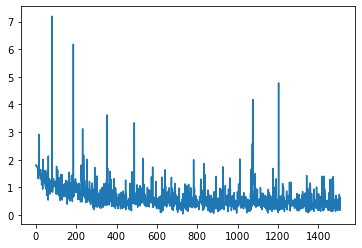

100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [22:18<00:00,  1.13it/s]


epoch: 2 of 6 
mean_loss: 0.3773021120220087 
mae_loss: 8.667412378821775


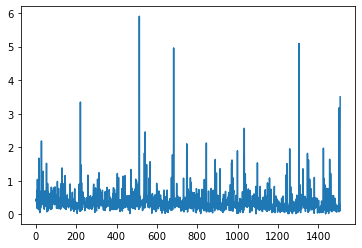

100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [22:20<00:00,  1.13it/s]


epoch: 3 of 6 
mean_loss: 0.13972824278262497 
mae_loss: 7.104399701715138


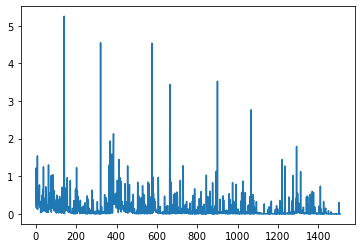

100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [22:18<00:00,  1.13it/s]


epoch: 4 of 6 
mean_loss: 0.059930062092561166 
mae_loss: 8.349739000745712


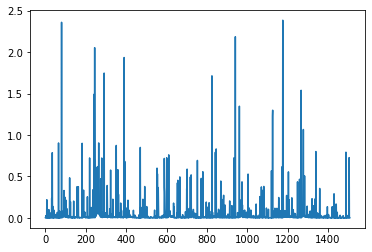

100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [22:17<00:00,  1.13it/s]


epoch: 5 of 6 
mean_loss: 0.058053679416946266 
mae_loss: 5.630872483221476


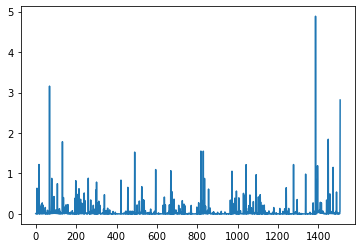

100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [21:49<00:00,  1.15it/s]


epoch: 6 of 6 
mean_loss: 0.035852809077948085 
mae_loss: 6.372110365398956


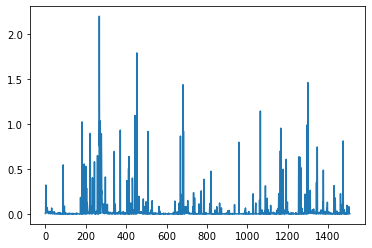

  0%|                                                                                         | 0/1509 [00:00<?, ?it/s]

Training finished
Training model...
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 4e-05
    weight_decay: 0
)
Criterion: NLLLoss()
epochs: 6


100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [21:22<00:00,  1.18it/s]


epoch: 1 of 6 
mean_loss: 0.01894941475342216 
mae_loss: 5.818791946308725


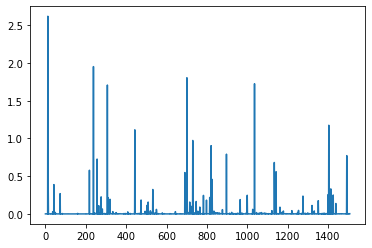

100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [21:19<00:00,  1.18it/s]


epoch: 2 of 6 
mean_loss: 0.018752688442402157 
mae_loss: 4.351976137211037


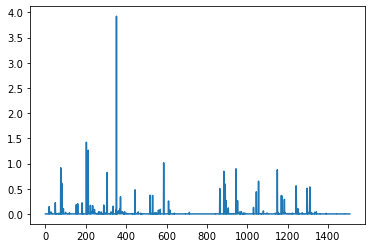

100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [21:19<00:00,  1.18it/s]


epoch: 3 of 6 
mean_loss: 0.021736095773521383 
mae_loss: 6.250559284116331


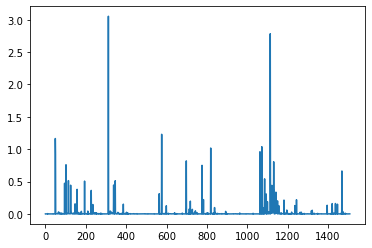

100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [21:21<00:00,  1.18it/s]


epoch: 4 of 6 
mean_loss: 0.01517277413791043 
mae_loss: 3.5824011931394484


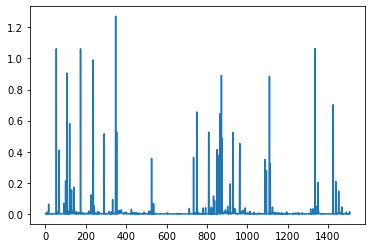

100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [21:23<00:00,  1.18it/s]


epoch: 5 of 6 
mean_loss: 0.013312217714482943 
mae_loss: 5.002982848620433


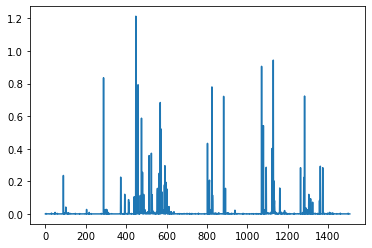

100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [21:45<00:00,  1.16it/s]


epoch: 6 of 6 
mean_loss: 0.010723369980598058 
mae_loss: 4.008202833706189


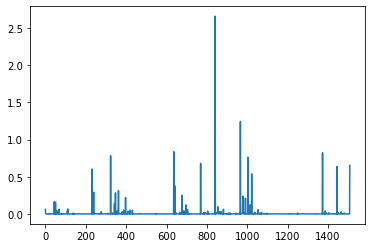

  0%|                                                                                         | 0/1509 [00:00<?, ?it/s]

Training finished
Training model...
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-05
    weight_decay: 0
)
Criterion: NLLLoss()
epochs: 6


100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [21:52<00:00,  1.15it/s]


epoch: 1 of 6 
mean_loss: 0.0071659559078526445 
mae_loss: 4.272184936614467


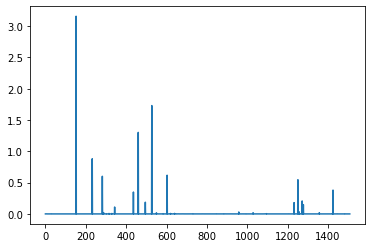

100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [21:53<00:00,  1.15it/s]


epoch: 2 of 6 
mean_loss: 0.003881426601513411 
mae_loss: 4.27069351230425


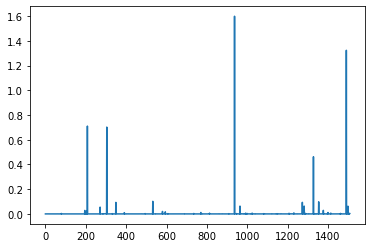

100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [21:57<00:00,  1.15it/s]


epoch: 3 of 6 
mean_loss: 0.0028231227868165676 
mae_loss: 4.199105145413871


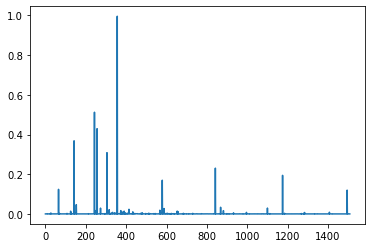

100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [21:59<00:00,  1.14it/s]


epoch: 4 of 6 
mean_loss: 0.0043260417406398724 
mae_loss: 3.967188665175242


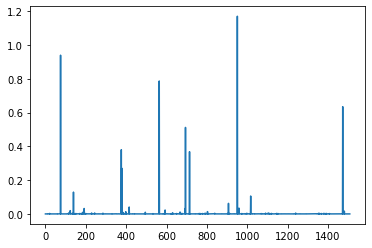

100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [22:07<00:00,  1.14it/s]


epoch: 5 of 6 
mean_loss: 0.0015507869970418072 
mae_loss: 4.554064131245339


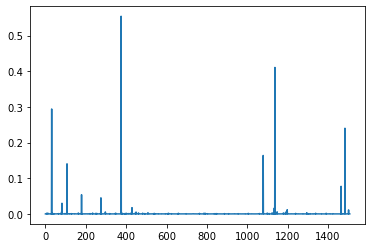

100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [21:43<00:00,  1.16it/s]


epoch: 6 of 6 
mean_loss: 0.002068746164953013 
mae_loss: 4.663683818046234


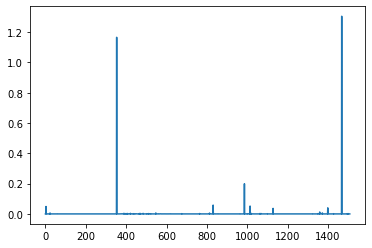

Training finished


In [ ]:
train_reg_via_class(epochs=6, lr=0.00006)
train_reg_via_class(epochs=6, lr=0.00004)
train_reg_via_class(epochs=6, lr=0.00001)

  0%|                                                                                         | 0/1509 [00:00<?, ?it/s]

Training model...
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 6e-05
    weight_decay: 0
)
Criterion: NLLLoss()
epochs: 3


100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [23:13<00:00,  1.08it/s]


epoch: 1 of 3 
mean_loss: 0.5991072714960757 
mae_loss: 7.779269202087994


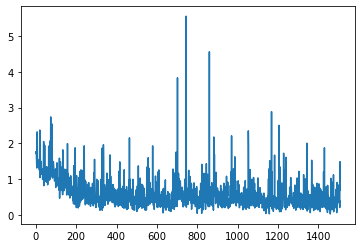

100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [23:09<00:00,  1.09it/s]


epoch: 2 of 3 
mean_loss: 0.368177243277728 
mae_loss: 7.272184936614467


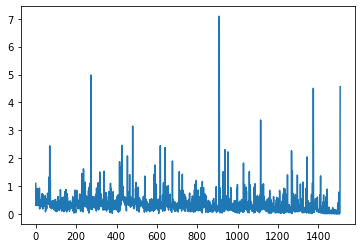

100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [23:12<00:00,  1.08it/s]


epoch: 3 of 3 
mean_loss: 0.11008101620801186 
mae_loss: 5.3340790454884415


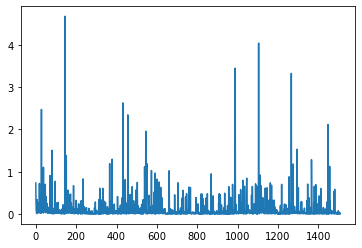

  0%|                                                                                         | 0/1509 [00:00<?, ?it/s]

Training finished
Training model...
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 4e-05
    weight_decay: 0
)
Criterion: NLLLoss()
epochs: 4


100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [23:07<00:00,  1.09it/s]


epoch: 1 of 4 
mean_loss: 0.0493564102814612 
mae_loss: 4.167785234899329


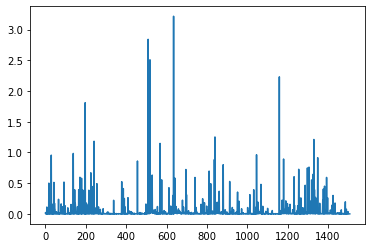

100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [23:39<00:00,  1.06it/s]


epoch: 2 of 4 
mean_loss: 0.04866988182981411 
mae_loss: 5.24683072334079


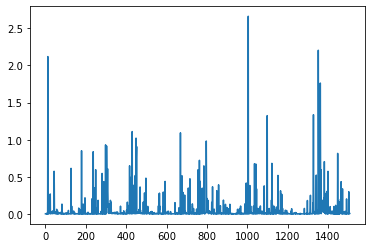

100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [24:03<00:00,  1.05it/s]


epoch: 3 of 4 
mean_loss: 0.03752006883896708 
mae_loss: 5.225205070842655


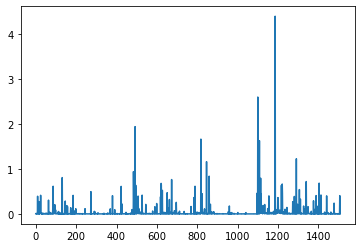

 34%|██████████████████████████▉                                                    | 515/1509 [08:13<15:51,  1.04it/s]


KeyboardInterrupt: ignored

In [ ]:
train_reg_via_class(epochs=3, lr=0.00006)
train_reg_via_class(epochs=4, lr=0.00004)
# train_reg_via_class(epochs=3, lr=0.00001)

  0%|                                                                                         | 0/1509 [00:00<?, ?it/s]

Training model...
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 1e-05
    weight_decay: 0
)
Criterion: NLLLoss()
epochs: 2


100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [07:03<00:00,  3.57it/s]


epoch: 1 of 2 
mean_loss: 0.0022914474088083043 
mae_loss: 0.2080536912751678


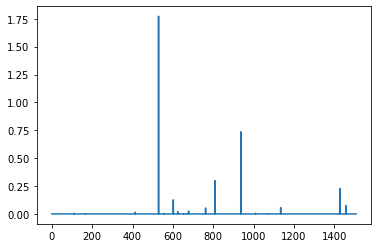

100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [07:07<00:00,  3.53it/s]


epoch: 2 of 2 
mean_loss: 0.001411595051652606 
mae_loss: 0.19910514541387025


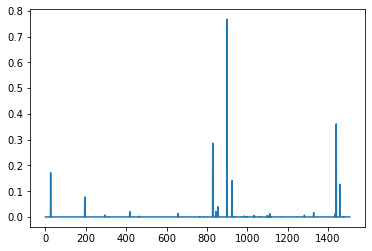

  0%|                                                                                         | 0/1509 [00:00<?, ?it/s]

Training finished
Training model...
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 7e-06
    weight_decay: 0
)
Criterion: NLLLoss()
epochs: 5


100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [07:07<00:00,  3.53it/s]


epoch: 1 of 5 
mean_loss: 0.0020060886012057827 
mae_loss: 0.14615958240119314


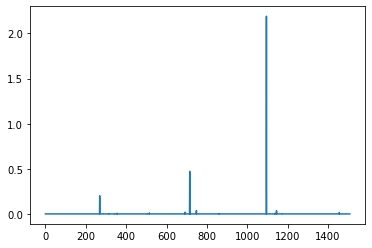

100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [07:08<00:00,  3.52it/s]


epoch: 2 of 5 
mean_loss: 0.0011991896144283771 
mae_loss: 0.1715137956748695


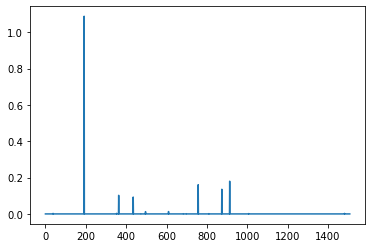

100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [07:11<00:00,  3.49it/s]


epoch: 3 of 5 
mean_loss: 6.718968395823709e-05 
mae_loss: 0.12900820283370618


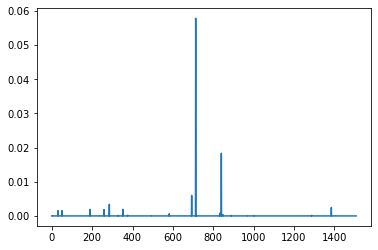

100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [07:11<00:00,  3.50it/s]


epoch: 4 of 5 
mean_loss: 0.0008365211141134499 
mae_loss: 0.16181953765846382


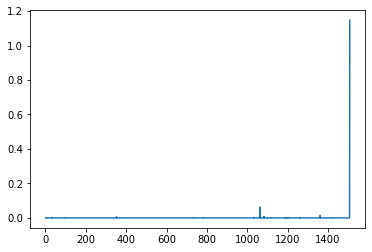

100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [07:11<00:00,  3.49it/s]


epoch: 5 of 5 
mean_loss: 0.0003724348219409443 
mae_loss: 0.06785980611483967


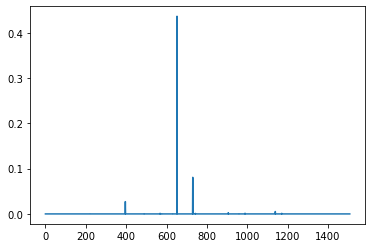

Training finished


In [ ]:
train_reg_via_class(epochs=2, lr=0.00001)
train_reg_via_class(epochs=5, lr=0.000007)

  0%|                                                                                         | 0/1509 [00:00<?, ?it/s]

Training model...
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 7e-06
    weight_decay: 0
)
Criterion: NLLLoss()
epochs: 2


100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [07:03<00:00,  3.56it/s]


epoch: 1 of 2 
mean_loss: 0.00041376781747592956 
mae_loss: 0.09545115585384041


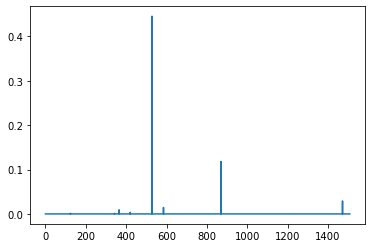

100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [07:10<00:00,  3.50it/s]


epoch: 2 of 2 
mean_loss: 0.0006393198281551492 
mae_loss: 0.08202833706189411


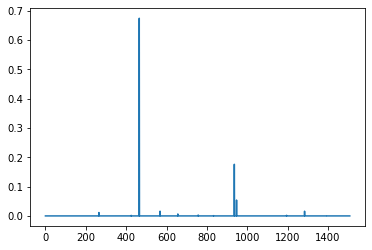

  0%|                                                                                         | 0/1509 [00:00<?, ?it/s]

Training finished
Training model...
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 3e-06
    weight_decay: 0
)
Criterion: NLLLoss()
epochs: 5


100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [08:50<00:00,  2.84it/s]


epoch: 1 of 5 
mean_loss: 0.0005425723789821448 
mae_loss: 0.06711409395973154


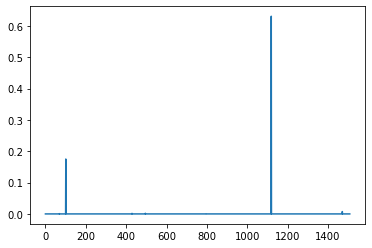

100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [07:13<00:00,  3.48it/s]


epoch: 2 of 5 
mean_loss: 3.8985504545500804e-05 
mae_loss: 0.0924683072334079


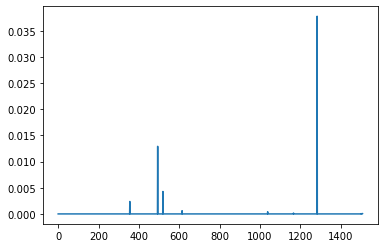

100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [07:19<00:00,  3.43it/s]


epoch: 3 of 5 
mean_loss: 8.274105978582217e-06 
mae_loss: 0.08202833706189411


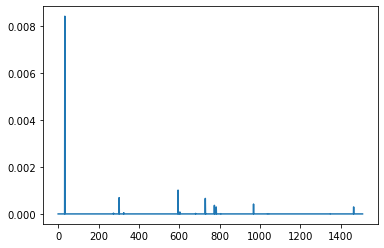

100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [07:22<00:00,  3.41it/s]


epoch: 4 of 5 
mean_loss: 0.00036488732317230927 
mae_loss: 0.09395973154362416


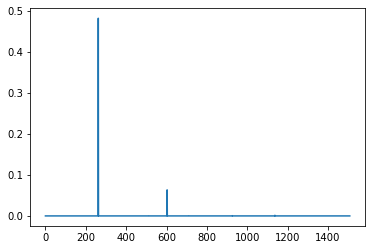

100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [07:19<00:00,  3.44it/s]


epoch: 5 of 5 
mean_loss: 0.00036006310412613625 
mae_loss: 0.06040268456375839


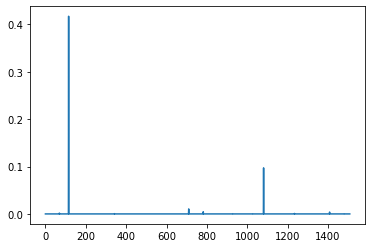

Training finished


In [ ]:
train_reg_via_class(epochs=2, lr=0.000007)
train_reg_via_class(epochs=5, lr=0.000003)

In [ ]:
mae(model, dataset_train)

0.030579265766139056

  0%|                                                                                         | 0/1509 [00:00<?, ?it/s]

Training model...
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 5e-06
    weight_decay: 0
)
Criterion: NLLLoss()
epochs: 10


100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [07:05<00:00,  3.54it/s]


epoch: 1 of 10 
mean_loss: 0.000314454522302173 
mae_loss: 0.08799403430275914


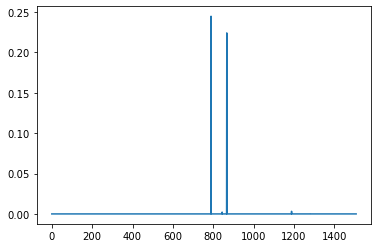

100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [07:15<00:00,  3.46it/s]


epoch: 2 of 10 
mean_loss: 0.000307493375449699 
mae_loss: 0.14168530947054436


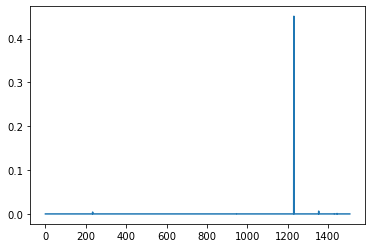

100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [07:23<00:00,  3.40it/s]


epoch: 3 of 10 
mean_loss: 0.00029751879739124205 
mae_loss: 0.07829977628635347


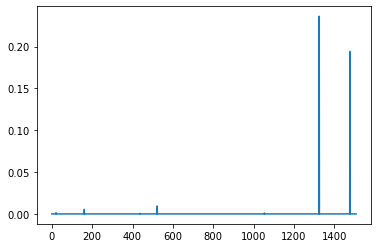

100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [07:24<00:00,  3.40it/s]


epoch: 4 of 10 
mean_loss: 5.809067945007639e-06 
mae_loss: 0.07233407904548844


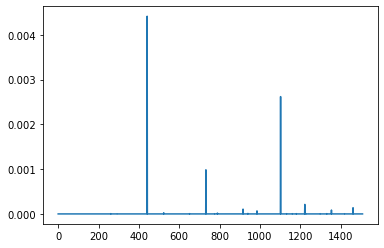

100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [07:22<00:00,  3.41it/s]


epoch: 5 of 10 
mean_loss: 3.229941836176237e-06 
mae_loss: 0.07009694258016405


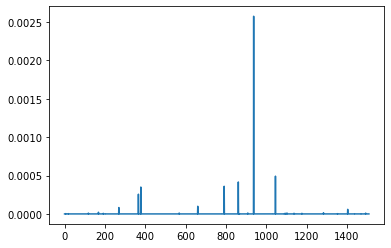

100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [07:23<00:00,  3.40it/s]


epoch: 6 of 10 
mean_loss: 2.726175117965947e-06 
mae_loss: 0.0738255033557047


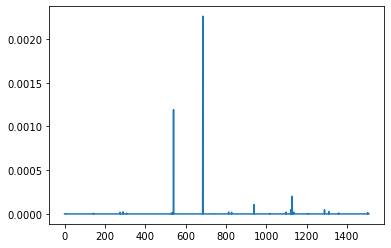

100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [07:24<00:00,  3.39it/s]


epoch: 7 of 10 
mean_loss: 0.0005318285346766209 
mae_loss: 0.026845637583892617


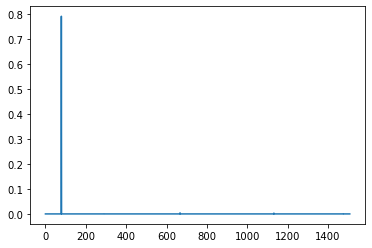

100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [07:14<00:00,  3.47it/s]


epoch: 8 of 10 
mean_loss: 0.000417637569813933 
mae_loss: 0.061894108873974646


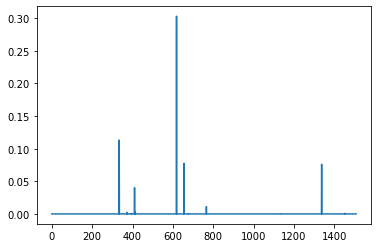

100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [07:12<00:00,  3.49it/s]


epoch: 9 of 10 
mean_loss: 1.7046948801560163e-06 
mae_loss: 0.08053691275167785


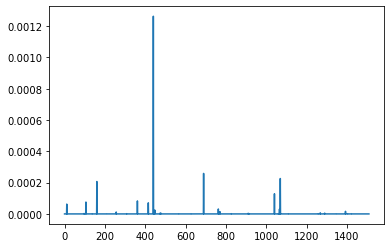

100%|██████████████████████████████████████████████████████████████████████████████| 1509/1509 [07:12<00:00,  3.49it/s]


epoch: 10 of 10 
mean_loss: 8.665387851306699e-06 
mae_loss: 0.06935123042505593


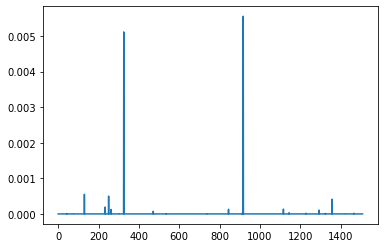

Training finished


In [ ]:
train_reg_via_class(epochs=10/, lr=0.000005)

In [ ]:
torch.save(model.state_dict(), 'C:\\Users\\Timofey\\Reg_via_class_idao_4.pth') # <-- save model

## Autoencoder

In [ ]:
class Autoencoder_model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, (3, 3), padding=1, padding_mode='reflect'),
            nn.SiLU(), 
            nn.Conv2d(64, 64, (3, 3), padding=1, padding_mode='reflect'),
            nn.SiLU(), 
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            nn.Conv2d(64, 128, (3, 3), padding=1, padding_mode='reflect'),
            nn.SiLU(),
            nn.Conv2d(128, 128, (3, 3), padding=1, padding_mode='reflect'),
            nn.SiLU(),
            nn.AvgPool2d((2, 2), stride=(2, 2)),
            nn.Conv2d(128, 256, (5, 5), padding=2, padding_mode='reflect'), 
            nn.SiLU(),
            nn.Conv2d(256, 256, (5, 5), padding=2, padding_mode='reflect'), 
            nn.SiLU(),
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            # nn.Conv2d(256, 256, (5, 5), padding=2, padding_mode='reflect'), 
            # nn.SiLU(),
            nn.Conv2d(256, 256, (5, 5), padding=2, padding_mode='reflect'), 
            nn.SiLU(),
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            # nn.Conv2d(256, 256, (3, 3), padding=1, padding_mode='reflect'), 
            # nn.SiLU(),
            nn.Conv2d(256, 256, (3, 3), padding=1, padding_mode='reflect'), 
            nn.SiLU(),
            nn.MaxPool2d((2, 2), stride=(2, 2)),
        )
         
        self.decoder = nn.Sequential(         
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, (3, 3), padding=1, padding_mode='reflect'),
            nn.SiLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, (3, 3), padding=1, padding_mode='reflect'),
            nn.SiLU(),
            nn.Upsample(scale_factor=2),
            # nn.Conv2d(128, 128, (3, 3), padding=1, padding_mode='reflect'),
            # nn.SiLU(),
            nn.Conv2d(128, 128, (3, 3), padding=1, padding_mode='reflect'),
            nn.SiLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 96, (3, 3), padding=1, padding_mode='reflect'),
            nn.SiLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(96, 64, (3, 3), padding=1, padding_mode='reflect'),
            nn.SiLU(),
            nn.Conv2d(64, 32, (3, 3), padding=1, padding_mode='reflect'),
            nn.SiLU(),
            nn.Conv2d(32, 1, (3, 3), padding=1, padding_mode='reflect'),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        h = self.encoder(x)
        # h = torch.cat((h, x), 1)
        h = self.decoder(h)
        return h

In [ ]:
model = Autoencoder_model().cuda()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

0 0.0010606684371603145


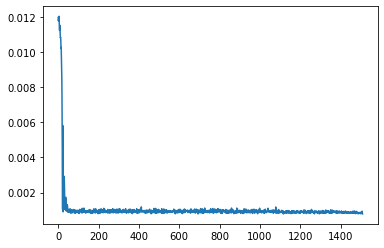

1 0.0008075036517528951


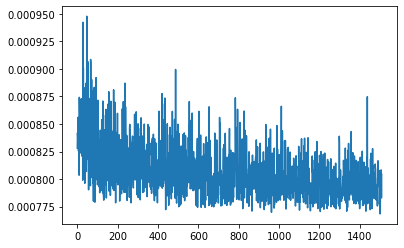

2 0.0007847884925720488


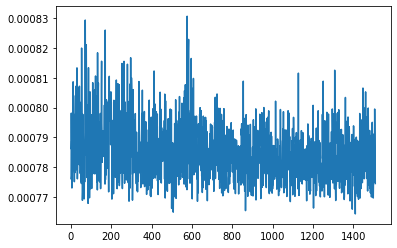

In [ ]:
for epoch in range(3):
    losses = []
    for X, y in loader:
        optimizer.zero_grad()
        y_pred = model(X.cuda())
        loss = criterion(y_pred, X.cuda())
        # break
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    print(epoch, np.mean(losses))
    plt.plot(losses)
    plt.show()
    

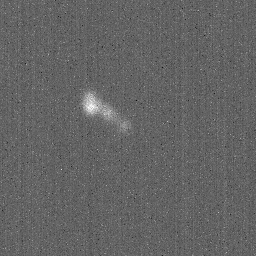

In [ ]:
transforms.ColorJitter(contrast=[3.0, 3.0])(transforms.CenterCrop((256, 256))(dataset.get_image(dataset_test[5][1]))) # ER 30 keV
# transforms.ColorJitter(contrast=[5.0, 5.0])(transforms.CenterCrop((256, 256))(dataset.get_image(dataset_test[16][1]))) # HR 20 keV

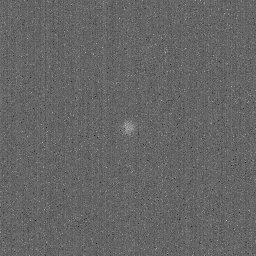

In [ ]:
transforms.ColorJitter(contrast=[3.0, 3.0])(transforms.CenterCrop((256, 256))(dataset.get_image(dataset_test[14][1]))) # ER 3 keV
# transforms.ColorJitter(contrast=[5.0, 5.0])(transforms.CenterCrop((256, 256))(dataset.get_image(dataset_test[17][1]))) # HR 1 keV

In [ ]:
dataset.get_filename(dataset_test[17][1])

'idao_dataset\\train\\NR\\-1.4997999668121338__CYGNO_60_40_He_NR_1_keV_930V_30cm_SRIM_IDAO_iso_crop_hist_pic_run4_ev861;1.png'

In [ ]:
dataset_test[2][0]

tensor([[[0.3804, 0.4039, 0.4275,  ..., 0.3725, 0.3725, 0.4039],
         [0.4275, 0.3725, 0.4667,  ..., 0.3490, 0.3961, 0.3647],
         [0.4118, 0.3961, 0.4039,  ..., 0.3569, 0.4196, 0.3804],
         ...,
         [0.3804, 0.3961, 0.3804,  ..., 0.3569, 0.3961, 0.4196],
         [0.4118, 0.3804, 0.4039,  ..., 0.4118, 0.2235, 0.3882],
         [0.3647, 0.3961, 0.3804,  ..., 0.3176, 0.3647, 0.4039]]])

In [ ]:
X_test = dataset_test[5][0]
y_test = model(X_test.view(1, 1, 256, 256).cuda())
y_test = y_test.detach().cpu()

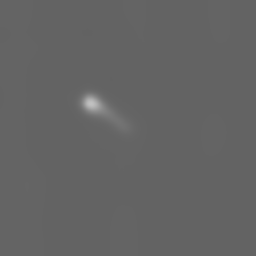

In [ ]:
transforms.ToPILImage()(y_test.view(256, 256))

# Conspect

## Classifier

* accuracy score: 0.9904153354632588 | auc-roc: 0.9991785422528818 - около 15 эпох простой модели с 4 содержательными сверточными слоями. Картинки без преобразований. (Adam, learning_rate = 0.001)
* accuracy score: 0.9880686055182699 | auc-roc: 0.9993794069889005 - 19 эпох такой же модели, но теперь добавил увеличение контрастности изображения. Это помогло сети обучиться быстрее до приличного качества. (learning_rate = 0.0009 - ухудшает модель)

## Regressor

* mae: 2.8 - 10 эпох простой модели из 3х сверток со скейлингом, loss = MSE.

In [ ]:
Class_model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=1, padding_mode='reflect'),
    nn.SiLU(),
    nn.Dropout(p=0.1),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, padding_mode='reflect'),
    nn.SiLU(),
    nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(3, 3), padding=1, padding_mode='reflect'),
    nn.SiLU(),
    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, padding_mode='reflect'),
    nn.SiLU(),
    nn.Conv2d(in_channels=16, out_channels=2, kernel_size=(256, 256), padding=0, padding_mode='reflect'),
    nn.LogSoftmax(dim=1)
    ).cuda()

class Reg_via_Class(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, (3, 3), padding=1, padding_mode='reflect'),
            nn.SiLU(), 
            nn.Conv2d(64, 64, (3, 3), padding=1, padding_mode='reflect'),
            nn.SiLU(), 
            nn.MaxPool2d((2, 2), stride=(2, 2)), # (*, 64, 128, 128)
            nn.Conv2d(64, 128, (3, 3), padding=1, padding_mode='reflect'),
            nn.SiLU(),
            nn.AvgPool2d((2, 2), stride=(2, 2)), # (*, 128, 64, 64)
            nn.Conv2d(128, 128, (3, 3), padding=1, padding_mode='reflect'),
            nn.SiLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, (5, 5), padding=2, padding_mode='reflect'), 
            nn.SiLU(),
            nn.Conv2d(256, 256, (5, 5), padding=2, padding_mode='reflect'), 
            nn.SiLU(),
            nn.MaxPool2d((2, 2), stride=(2, 2)), # (*, 256, 32, 32)
            nn.Conv2d(256, 256, (5, 5), padding=2, padding_mode='reflect'), 
            nn.SiLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, (5, 5), padding=2, padding_mode='reflect'), 
            nn.SiLU(),
            nn.Dropout(0.1),
            nn.Conv2d(256, 256, (5, 5), padding=2, padding_mode='reflect'), 
            nn.SiLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, (5, 5), padding=2, padding_mode='reflect'), 
            nn.SiLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, (3, 3), padding=1, padding_mode='reflect'), 
            nn.SiLU(),
            nn.MaxPool2d((2, 2), stride=(2, 2)), # (*, 256, 16, 16)
            nn.Conv2d(256, 256, (3, 3), padding=1, padding_mode='reflect'), 
            nn.SiLU(),
            nn.MaxPool2d((2, 2), stride=(2, 2)), # (*, 256, 8, 8)
            nn.Conv2d(256, 256, (3, 3), padding=1, padding_mode='reflect'), 
            nn.SiLU(),
            nn.Dropout(0.1),
            nn.MaxPool2d((2, 2), stride=(2, 2)), # (*, 256, 4, 4)
            nn.Conv2d(256, 128, (3, 3), padding=1, padding_mode='reflect'), 
            nn.SiLU(),
            nn.Conv2d(128, 64, (3, 3), padding=1, padding_mode='reflect'), 
            nn.SiLU(),
            # nn.MaxPool2d((2, 2), stride=(2, 2)), # (*, 64, 2, 2)
            nn.Conv2d(64, 64, (3, 3), padding=1, padding_mode='reflect'), 
            nn.SiLU(),
            nn.Conv2d(64, 32, (3, 3), padding=1, padding_mode='reflect'), 
            nn.SiLU(),
            nn.Conv2d(32, 6, (4, 4), padding=0, padding_mode='reflect'),
            # nn.MaxPool2d((2, 2), stride=(2, 2)), # (*, 4, 1, 1)
            nn.LogSoftmax(dim=1),
        )
    
    def forward(self, x):
        h = self.encoder(x)
        # h = torch.cat((h, x), 1)
        return h


model_reg = Reg_via_Class().cuda()
model_reg.load_state_dict(torch.load('C:\\Users\\Timofey\\Reg_via_class_idao_3.pth'))
model_reg.eval()
Class_model.load_state_dict(torch.load('C:\\Users\\Timofey\\class_idao_2.pth'))
Class_model.eval()

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (1): SiLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (4): SiLU()
  (5): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (6): SiLU()
  (7): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (8): SiLU()
  (9): Conv2d(16, 2, kernel_size=(256, 256), stride=(1, 1), padding_mode=reflect)
  (10): LogSoftmax(dim=1)
)

In [ ]:
import pandas as pd
res = pd.DataFrame(columns=['id','classification_predictions','regression_predictions'])
res

,id,classification_predictions,regression_predictions


In [ ]:
cnt = 0
names = []
classes = []
regress = []
for X, y in tqdm(loader_test):
    predicted_class = Class_model(X.cuda())
    predicted_reg = model_reg(X.cuda()).detach().view(-1, 6)
    # print(predicted_class)
    # print((predicted_class.detach().cpu().view(-1, 2)[:, 1].numpy() - predicted_class.detach().cpu().view(-1, 2)[:, 0].numpy()))
    pred_cl = (predicted_class.detach().cpu().view(-1, 2)[:, 1].numpy() - predicted_class.detach().cpu().view(-1, 2)[:, 0].numpy())
    for i in range(len(y)):
        _name = dataset_test.get_filename(y[i])
        names.append(_name.split('\\')[-1].split('.')[0])
        classes.append(pred_cl[i])
        regress.append(kev_inverse_transform(predicted_reg[i].argmax().item()))

100%|██████████████████████████████████████████████████████████████████████████████| 2070/2070 [05:41<00:00,  6.07it/s]


In [ ]:
classes_np = np.array(classes)
classes_np -= np.min(classes_np)
mx = np.max(classes_np) + 2
print(mx)
classes_np /= mx
classes

1066.771728515625


[-53.203705,
 -131.33548,
 -5.008401,
 13.402054,
 -6.373686,
 -22.61243,
 -48.612988,
 15.6326885,
 -3.522111,
 -159.24908,
 9.402027,
 10.440908,
 2.5224998,
 -9.815416,
 -40.74845,
 21.725273,
 -305.98944,
 -280.2185,
 -398.27606,
 3.1765423,
 11.623511,
 3.7383714,
 -583.2445,
 20.508276,
 -122.826645,
 -9.877887,
 -0.6040416,
 -39.545418,
 3.4020534,
 12.375378,
 -12.4686775,
 4.0739007,
 -22.840424,
 11.548605,
 -467.64313,
 -204.70386,
 -319.4458,
 -49.340523,
 -53.677258,
 5.959961,
 15.033629,
 8.738552,
 3.0800838,
 6.131564,
 13.574363,
 -44.900852,
 -1.1732116,
 19.73363,
 12.063641,
 -1.8285189,
 21.346521,
 -580.3758,
 6.8177433,
 -3.4643703,
 11.769508,
 -8.354874,
 -32.484108,
 -58.217632,
 -1.2295456,
 -61.95923,
 11.057935,
 -4.431042,
 1.9227241,
 2.0487962,
 -12.522116,
 11.058496,
 17.408802,
 -607.03754,
 6.078636,
 8.374588,
 3.5935411,
 -48.02168,
 3.4641352,
 14.710305,
 -64.26258,
 11.4686575,
 14.861044,
 8.688465,
 1.3797747,
 1.8714092,
 12.345861,
 -32.375

In [ ]:
res['id'] = names
res['classification_predictions'] = classes_np
res['regression_predictions'] = regress
res

,id,classification_predictions,regression_predictions
0,00013a94f1fae3e5a33f8b44c2842c85f0483e96,0.889891,10
1,0005564c011259402dcb6e3beb6e64d285124fa0,0.816650,30
2,0007520c8d8efade8feaafbf74fc7d206cdf229d,0.935070,30
3,000804a189f630cd980ff1543c0ef99d48cd6b34,0.952328,1
4,000eb12def5371089743dcfe401a8e399f5883fc,0.933790,30
...,...,...,...
16555,ff343a62752061d995f94ebc10ac53f79d1b5ab1,0.918638,3
16556,ff897755cb312cd6f510ba7a38cb293e648d97d5,0.913169,3
16557,ff9a93402457ac514cd069a7ce3f2e32692f5290,0.972581,20
16558,ffedc12ec5c142dae2086408b778cf0db2ff944e,0.910288,3


In [ ]:
res.to_csv('C:\\Users\\Timofey\\result_idao2021_2.csv', index=False)

'000a95ca23df016a149ff9af94b6e9d8633d6691'